Raphaël Razafindralambo Computational Statistics HW4

In [112]:
import numpy as np
from numba import jit
import time
from scipy.stats import invgamma
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import random

## $\textbf{Exercise 1:}$


In [ ]:
def log_dpi(x,y,a):
    return -x**2/a**2 - y**2 - 0.25*(x**2/a**2 - y**2)**2

In [54]:
def HM_within_Gibbs(x0, y0, a, sigmas, batch_size=20, maxIter = 1000, verbose=0):

    start = time.time()

    # Initialization
    x,y = x0,y0
    sigma_1,sigma_2 = sigmas


    if verbose > 0: its = tqdm(range(maxIter))
    else: its = range(maxIter)

    acc = 0
    acc_x = 0
    acc_y = 0
    accs_x = []
    accs_y = []
    sample = []
    i = 0
    for k in its:
        i += 1
        # Proposal
        if np.random.binomial(1, 0.5) == 0:
              # We change x and y is constant
              x_new = np.random.normal(loc=x, scale=sigma_1)
              # Yn+1 = (x_n+1, y_n)
              log_alpha = min(0,log_dpi(x_new,y,a) - log_dpi(x,y,a))
              log_u = np.log(np.random.rand())
              # Acceptance rejection
              if log_u < log_alpha:
                    x,y = x_new,y
                    acc += 1
                    acc_x += 1

        else:
              # We change y and x is constant
              y_new = np.random.normal(loc=y, scale=sigma_2)
              # Yn+1 = (x_n, y_n+1)
              log_alpha = min(0,log_dpi(x,y_new,a) - log_dpi(x,y,a))
              log_u = np.log(np.random.rand())
              # Acceptance rejection
              if log_u < log_alpha:
                    x,y = x,y_new
                    acc += 1
                    acc_y += 1


        # Save
        sample.append((x,y))

        if (k % batch_size == 0):
            accs_x.append(acc_x / batch_size)
            accs_y.append(acc_y / batch_size)
            acc_x = 0
            acc_y = 0
    if verbose > 1:
        print("Taux d'acceptation: ", acc/maxIter)
        print(f"Execution time of Symetric Random Walk MH: {time.time() - start} s.")
    return (x,y),sample,accs_x,accs_y


  0%|          | 0/10000 [00:00<?, ?it/s]

Taux d'acceptation:  0.5622
Execution time of Symetric Random Walk MH: 0.22089576721191406 s.


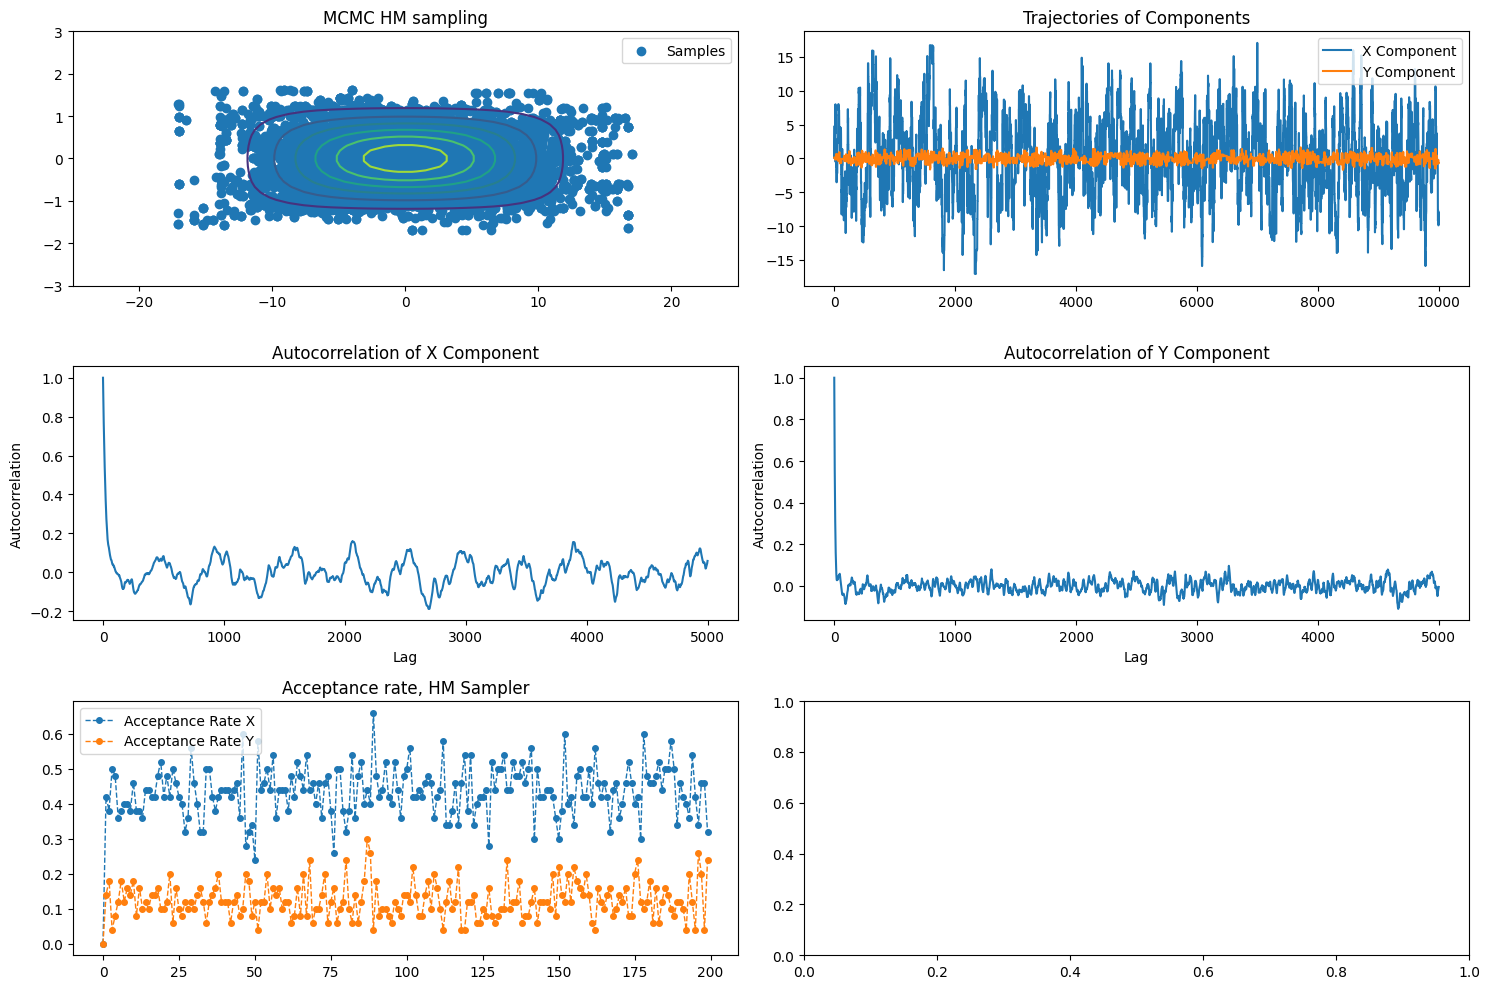

In [ ]:
sigmas = (3,3)
a = 10
_,sample,accs_x,accs_y = HM_within_Gibbs(0.1, 0.1, a, sigmas,batch_size = 50, maxIter = 10000, verbose=2)
sample = np.array(sample)

x = np.linspace(-25, 25)
y = np.linspace(-3, 3)
X, Y = np.meshgrid(x, y)
Z = np.exp(log_dpi(X, Y, 10)).reshape(X.shape)

# Création des subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 10))  # 2 lignes, 2 colonnes

# Premier subplot (en haut à gauche): Graphe de contour avec échantillons
axes[0, 0].contour(X, Y, Z)
axes[0, 0].scatter(sample[:,0], sample[:,1], label='Samples')
axes[0, 0].set_title('MCMC HM sampling')
axes[0, 0].legend()

# Deuxième subplot (en haut à droite): Trajectoires des composantes x et y
axes[0, 1].plot(sample[:,0], label='X Component')
axes[0, 1].plot(sample[:,1], label='Y Component')
axes[0, 1].set_title('Trajectories of Components')
axes[0, 1].legend()


df_sample = pd.DataFrame(sample, columns=['X', 'Y'])

# Autocorr of componant x
autocorr_x = [df_sample['X'].autocorr(lag=i) for i in range(len(df_sample)//2)]
axes[1, 0].plot(autocorr_x)
axes[1, 0].set_title('Autocorrelation of X Component')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Autocorrelation')

# Autocorr of componant y
autocorr_y = [df_sample['Y'].autocorr(lag=i) for i in range(len(df_sample)//2)]
axes[1, 1].plot(autocorr_y)
axes[1, 1].set_title('Autocorrelation of Y Component')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')

axes[2, 0].plot(accs_x, linestyle='--', linewidth=1, marker = 'o', markersize=4, label='Acceptance Rate X')
axes[2, 0].plot(accs_y, linestyle='--', linewidth=1, marker = 'o', markersize=4,label='Acceptance Rate Y')
axes[2, 0].set_title('Acceptance rate, HM Sampler')
axes[2, 0].legend()
# Affichage des graphiques
plt.tight_layout()
plt.show()

In [ ]:
def adaptative_HM_within_Gibbs(x0, y0, a, l=(0,0), batch_size=20, maxIter = 1000, verbose=0):

    start = time.time()

    # Initialization
    x,y = x0,y0


    if verbose > 0: its = tqdm(range(maxIter))
    else: its = range(maxIter)

    acc = 0
    acc_x = 0
    acc_y = 0
    accs_x = []
    accs_y = []
    sample = []
    j = 0
    lx,ly = l
    for k in its:
        # Proposal
        if np.random.binomial(1, 0.5) == 0:
              # We change x and y is constant
              sigma_1 = np.exp(lx) # Adaptative
              x_new = np.random.normal(loc=x, scale=sigma_1)
              # Yn+1 = (x_n+1, y_n)
              log_alpha = min(0,log_dpi(x_new,y,a) - log_dpi(x,y,a))
              log_u = np.log(np.random.rand())
              # Acceptance rejection
              if log_u < log_alpha:
                    x,y = x_new,y
                    acc += 1
                    acc_x += 1

        else:
              # We change y and x is constant
              sigma_2 = np.exp(ly) # Adaptative
              y_new = np.random.normal(loc=y, scale=sigma_2)
              # Yn+1 = (x_n, y_n+1)
              log_alpha = min(0,log_dpi(x,y_new,a) - log_dpi(x,y,a))
              log_u = np.log(np.random.rand())
              # Acceptance rejection
              if log_u < log_alpha:
                    x,y = x,y_new
                    acc += 1
                    acc_y += 1


        # Save
        sample.append((x,y))

        if (k % batch_size == 0):
            j += 1
            delta_j = min(0.01,1/np.sqrt(j))
            accs_x.append(acc_x / batch_size)
            accs_y.append(acc_y / batch_size)
            if accs_x[-1] > 0.24:
              lx += delta_j
            else:
              lx -= delta_j
            if accs_y[-1] > 0.24:
              ly += delta_j
            else:
              ly -= delta_j
            acc_x = 0
            acc_y = 0


    if verbose > 1:
        print("Taux d'acceptation: ", acc/maxIter)
        print(f"Execution time of Symetric Random Walk MH: {time.time() - start} s.")
    return (x,y),sample,accs_x,accs_y


  0%|          | 0/20000 [00:00<?, ?it/s]

Taux d'acceptation:  0.6092
Execution time of Symetric Random Walk MH: 0.4852132797241211 s.


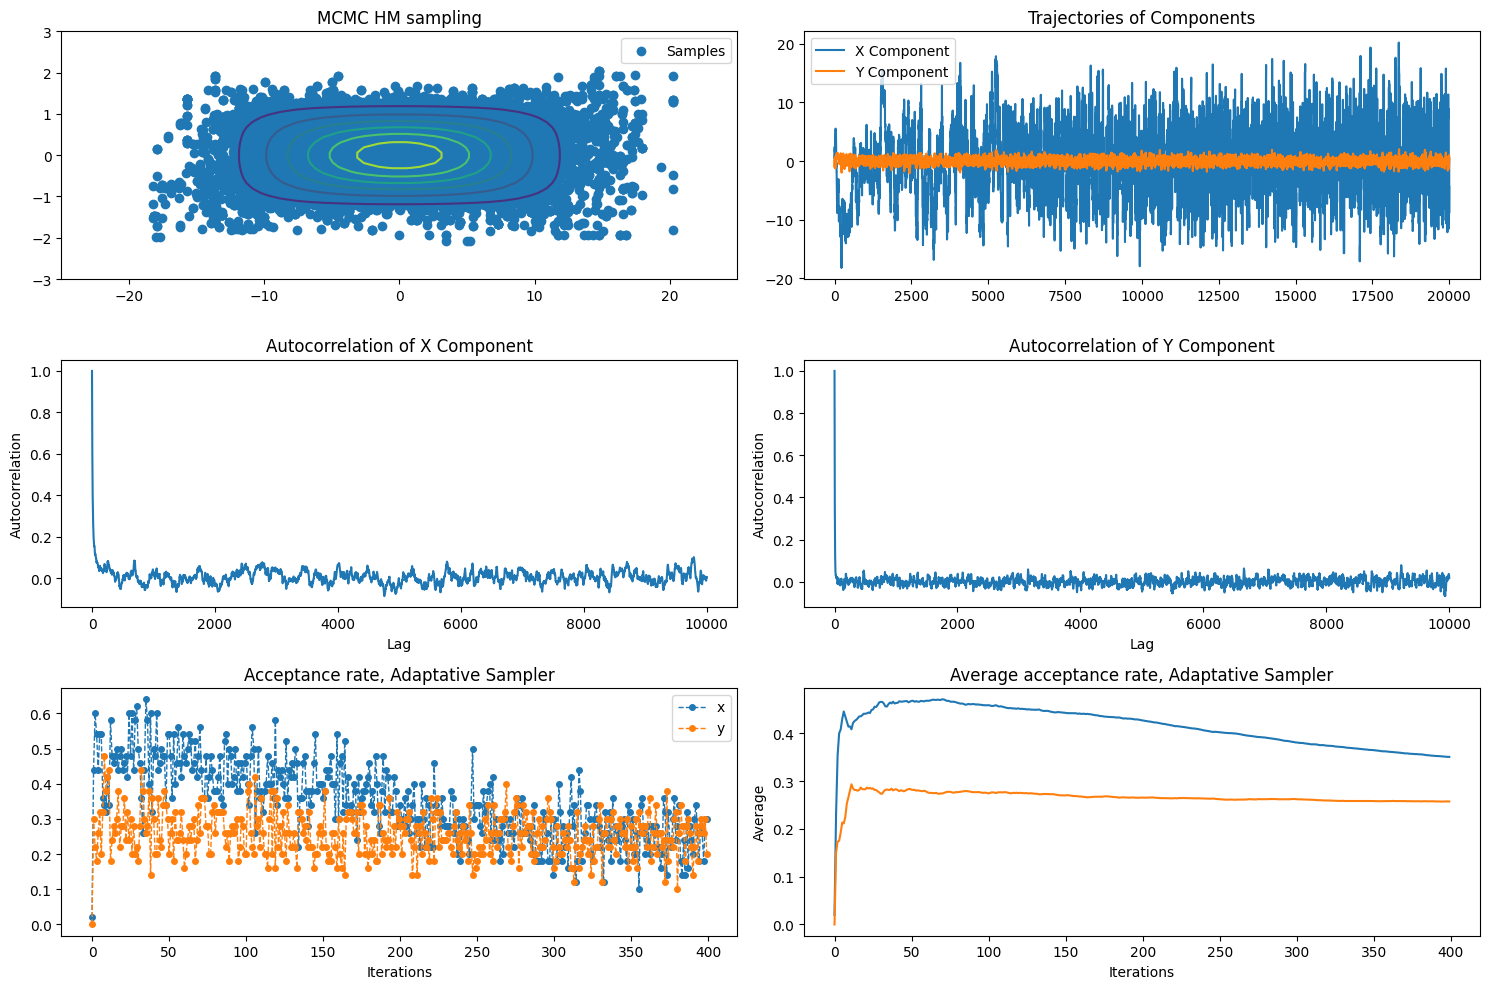

In [ ]:
a = 10
_,sample,accs_x,accs_y = adaptative_HM_within_Gibbs(0.1, 0.1, a, l=(0,0), batch_size = 50, maxIter = 20000, verbose=2)
sample = np.array(sample)

x = np.linspace(-25, 25)
y = np.linspace(-3, 3)
X, Y = np.meshgrid(x, y)
Z = np.exp(log_dpi(X, Y, 10)).reshape(X.shape)

# Création des subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 10))  # 2 lignes, 2 colonnes

# Premier subplot (en haut à gauche): Graphe de contour avec échantillons
axes[0, 0].contour(X, Y, Z)
axes[0, 0].scatter(sample[:,0], sample[:,1], label='Samples')
axes[0, 0].set_title('MCMC HM sampling')
axes[0, 0].legend()

# Deuxième subplot (en haut à droite): Trajectoires des composantes x et y
axes[0, 1].plot(sample[:,0], label='X Component')
axes[0, 1].plot(sample[:,1], label='Y Component')
axes[0, 1].set_title('Trajectories of Components')
axes[0, 1].legend()


df_sample = pd.DataFrame(sample, columns=['X', 'Y'])

# Autocorr of componant x
autocorr_x = [df_sample['X'].autocorr(lag=i) for i in range(len(df_sample)//2)]
axes[1, 0].plot(autocorr_x)
axes[1, 0].set_title('Autocorrelation of X Component')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Autocorrelation')

# Autocorr of componant y
autocorr_y = [df_sample['Y'].autocorr(lag=i) for i in range(len(df_sample)//2)]
axes[1, 1].plot(autocorr_y)
axes[1, 1].set_title('Autocorrelation of Y Component')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')

axes[2, 0].plot(accs_x, linestyle='--', linewidth=1, marker = 'o', markersize=4, label='x')
axes[2, 0].plot(accs_y, linestyle='--', linewidth=1, marker = 'o', markersize=4,label='y')
axes[2, 0].set_title('Acceptance rate, Adaptative Sampler')
axes[2, 0].set_xlabel('Iterations')
axes[2, 0].legend()

# Means
cum_accs_x = np.cumsum(accs_x) / np.arange(1, len(accs_x) + 1)
cum_accs_y = np.cumsum(accs_y) / np.arange(1, len(accs_y) + 1)
axes[2, 1].plot(cum_accs_x, linestyle='-', label='x')
axes[2, 1].plot(cum_accs_y, linestyle='-',label='y')
axes[2, 1].set_xlabel('Iterations')
axes[2, 1].set_ylabel('Average')
axes[2, 1].set_title('Average acceptance rate, Adaptative Sampler')
# Affichage des graphiques
plt.tight_layout()
plt.show()

#### Q2

In [ ]:
file_path = "/content/tmalaexcov.txt"
with open(file_path, 'r') as file:
    content = file.read()

rows = content.strip().split('\n')
matrix = np.array([list(map(float, row.split())) for row in rows])

d = matrix.shape[0]
if np.array_equal(matrix, matrix.T): print("The matrix is symetric.")

Mu = np.zeros(d)
Sigma = matrix
X_gauss  = np.random.multivariate_normal(Mu, Sigma, 500)

The matrix is symetric.


In [ ]:
def log_fB(x,B):
    return -(x[0]**2)/200 - 0.5*(x[1]+B*x[0]**2 -100*B)**2 - 0.5*np.sum(np.square(x[2:]))

In [52]:
def adaptative_HM_within_Gibbs_2(x0, B, l=np.zeros(d), batch_size=20, maxIter = 1000, verbose=0):

    start = time.time()

    # Initialization
    x = x0
    d = x0.shape[0]
    sample = np.zeros((maxIter,d))
    sample[0] = x

    if verbose > 0: its = tqdm(range(maxIter))
    else: its = range(maxIter)


    acc_x = np.zeros(d)

    sample = []
    j = 0

    for k in its:
        # Proposal

        if np.random.binomial(1, 0.5) == 0:
              # We change x and y is constant
              sigma_1 = np.exp(lx) # Adaptative
              x_new = np.random.normal(loc=x, scale=sigma_1)
              # Yn+1 = (x_n+1, y_n)
              log_alpha = min(0,log_dpi(x_new,y,a) - log_dpi(x,y,a))
              log_u = np.log(np.random.rand())
              # Acceptance rejection
              if log_u < log_alpha:
                    x,y = x_new,y
                    acc += 1
                    acc_x += 1

        else:
              # We change y and x is constant
              sigma_2 = np.exp(ly) # Adaptative
              y_new = np.random.normal(loc=y, scale=sigma_2)
              # Yn+1 = (x_n, y_n+1)
              log_alpha = min(0,log_dpi(x,y_new,a) - log_dpi(x,y,a))
              log_u = np.log(np.random.rand())
              # Acceptance rejection
              if log_u < log_alpha:
                    x,y = x,y_new
                    acc += 1
                    acc_y += 1


        # Save
        sample.append((x,y))

        if (k % batch_size == 0):
            j += 1
            delta_j = min(0.01,1/np.sqrt(j))
            accs_x.append(acc_x / batch_size)
            accs_y.append(acc_y / batch_size)
            if accs_x[-1] > 0.24:
              lx += delta_j
            else:
              lx -= delta_j
            if accs_y[-1] > 0.24:
              ly += delta_j
            else:
              ly -= delta_j
            acc_x = 0
            acc_y = 0


    if verbose > 1:
        print("Taux d'acceptation: ", acc/maxIter)
        print(f"Execution time of Symetric Random Walk MH: {time.time() - start} s.")
    return (x,y),sample,accs_x,accs_y


### Exercise 2

In [53]:
def pi(x,mu,sigma,w):
  res = 0
  for i in range(20):
      res += w[i]/(2*np.pi*sigma[i]**2) * np.exp(-(np.linalg.norm(x-mu[i,:])**2)/(2*sigma[i]**2))
  return res

In [57]:
x = np.arange(5)
x[3:1]

array([], dtype=int64)

In [84]:
def HM_SRW(x0, mu, sigma, w, sigma_prop, maxIter = 1000, verbose=0):

    start = time.time()

    # Initialization

    x = x0 # Size 2
    sample = [x0]


    if verbose > 0: its = tqdm(range(maxIter))
    else: its = range(maxIter)

    acc = 0


    for k in its:

        # Proposal
        x_new = np.random.normal(loc=x, scale=sigma_prop)

        #Acceptance
        alpha = min(1,pi(x_new,mu,sigma,w)/pi(x,mu,sigma,w)) # Symetric random walk
        u = np.random.rand()
        if u < alpha:
            x = x_new
            acc += 1

        # Save
        sample.append(x)

    if verbose > 1:
        print("Taux d'acceptation: ", acc/maxIter)
        print(f"Execution time of Symetric Random Walk MH: {time.time() - start} s.")
    return x,sample

In [94]:
d = 2
p = 20
mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],
 [4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],
 [8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31], [5.54,6.86],[1.69,8.11]])
sigma = 0.1*np.ones(p)
w = 0.05*np.ones(p)
x0 = np.ones(d)

In [95]:
x,sample = HM_SRW(x0=x0, mu=mu, sigma=sigma, w=w, sigma_prop = 1, maxIter = 1000, verbose=2)

  0%|          | 0/1000 [00:00<?, ?it/s]

Taux d'acceptation:  0.048
Execution time of Symetric Random Walk MH: 0.860440731048584 s.


In [96]:
sample = np.array(sample)

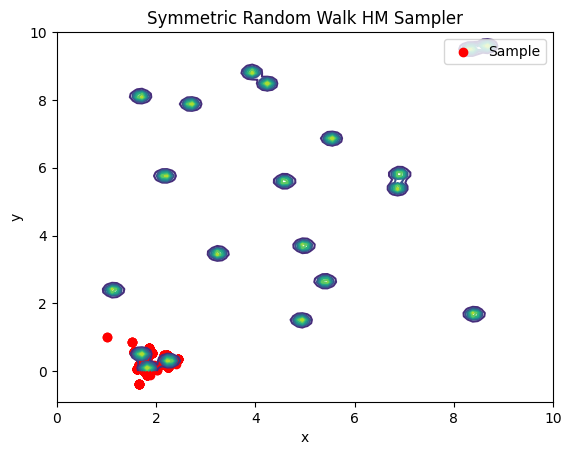

In [102]:
x = np.linspace(0, 10, 100)  # Ajuster les limites et la résolution selon les besoins
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)


Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = pi(np.array([X[i, j], Y[i, j]]), mu, sigma, w)

plt.contour(X, Y, Z)
plt.scatter(sample[:,0],sample[:,1],color="red",label="Sample")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Symmetric Random Walk HM Sampler')
plt.legend()
plt.show()

#### 2.B Parallel Tempering

In [111]:
sample = np.zeros((5,1000,2))
x0 = np.zeros((5,2)) # size (T,d)
print(x0)
sample[:,0,:] = x0

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [147]:
def Parallel_Tempering(x0, T, mu, sigma, w, maxIter = 1000, verbose=0):

    start = time.time()

    # Initialization
    x = x0 # (T,d)
    K = len(T)
    sample = np.zeros((K,maxIter,x0.shape[1])) # (K,N,d)
    sample[:,0,:] = x


    if verbose > 0: its = tqdm(range(maxIter))
    else: its = range(maxIter)

    for k in its:

        for i in range(K):
            T_i = T[i]
            tau_i = 0.25*np.sqrt(T_i)
            x_i = sample[i,k,:] #
            # Proposal for temperature i
            x_new_i = np.random.normal(x_i,(tau_i**2)*np.eye(2))
            print(x_new_i.shape)
            print(x_i.shape)
            # Acceptance
            alpha = min(1,pi(x_new_i,mu,sigma,w)/pi(x_i,mu,sigma,w)) # Symetric random walk
            u = np.random.rand()
            if u < alpha:
                x_i = x_new_i


            # Save

            sample[i,k+1,:] = x_i

        # Choose uniformly (i,j)
        i = np.random.randint(0,K)
        j = np.random.choice([i-1 , i+1])
        if i == 0 : j = i+1
        if i == K-1 : j = i-1

        # Swap acceptance probability
        T_i,T_j = T[i],T[j]
        up = (pi(sample[j,k+1,:],mu,sigma,w)**(1/T_i)) * (pi(sample[i,k+1,:],mu,sigma,w)**(1/T_j))
        bot = (pi(sample[i,k+1,:],mu,sigma,w)**(1/T_i)) * (pi(sample[j,k+1,:],mu,sigma,w)**(1/T_j))
        alpha = min(1, up/bot)

        # Swap
        u = np.random.rand()
        if u <= alpha :
            temp = sample[i,k+1,:]
            sample[i,k+1,:] = sample[j,k+1,:]
            sample[j,k+1,:] = temp




    if verbose > 1:
        print(f"Execution time of Symetric Random Walk MH: {time.time() - start} s.")
    return sample

In [148]:
d = 2
p = 20
mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],
 [4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],
 [8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31], [5.54,6.86],[1.69,8.11]])
sigma = 0.1*np.ones(p)
w = 0.05*np.ones(p)
x0 = np.ones(d)
T = np.array([60, 21.6, 7.7, 2.8, 1]).reshape(len(T),1)
x0 = np.zeros((len(T),d))
sample = Parallel_Tempering(x0, T, mu, sigma, w, maxIter = 1000, verbose=0)

(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 2)
(2,)
(2, 

ValueError: ignored

In [137]:
random.randint(0,4)

3